# Импортируем библиотеки и зафиксируем сиды

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import pickle
import datetime
import time
import random


from tqdm.auto import tqdm

RANDOM_STATE = 12345
np.random.seed(RANDOM_STATE)
# HOG
from skimage.feature import hog
from skimage import exposure

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import optuna

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from sklearn.utils import shuffle

# image size
# H = 64
# W = 64
# IMG_SIZE_CV = (H, W)
# ING_SIZE_CV = (H, W)

C:\Users\t.ermeshev\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# # импорты для google colab
# import glob
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# dirname = "/gdrive/My Drive/deepfake"

## Считывание картинок и вырезание лиц

In [3]:
def get_pictures(frames_path = os.path.join('datasets','frames'),                 
                 labels = {'real' : 0, 'fake' : 1},
                 phases = ['train'],
                 сrop = False,
                 sample_num = None,
                 H = 144,
                 W = 144,
                 frac_h = 1,
                 frac_v = 1,
                 gray = False
                ):
    """
    sample_num = 10
    frames_path
    labels = {'real' : 0, 'fake' : 1} or ['real', 'fake']
    phases = ['train', 'val', 'test']
    H = 256
    W = 256
    IMG_SIZE_CV = (H, W)
    frac_h = 0.8
    frac_v = 0.5
    
    """
    
    IMG_SIZE_CV = (H, W)
    images, target = [], []
    links = []
    faces = []  
    no_faces = []    
    
    for phase in tqdm(phases, desc='phase'):

        for label in labels:
            folder_link = os.path.join(frames_path, phase, label)
            # Sample or all pictures
            if sample_num is None or sample_num >= len(os.listdir(folder_link)):
                pic_links = os.listdir(folder_link)
            else:
                pic_links = np.random.choice(os.listdir(folder_link), sample_num)
            
            filelist = [os.path.join(folder_link,i) for i in pic_links]

            for fname in tqdm(filelist, desc='downloading pictures'):
                img = cv2.imread(fname)
                if gray is True:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if сrop is True:
                    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
                    face = face_cascade.detectMultiScale(img)
                    for (a, b, w, h) in face:
                        c_a = min(a,w)
                        c_a = int(c_a-c_a*frac_h)
                        c_b = min(b,h)
                        c_b = int(c_b-c_b*frac_v)
                        face = img[b-c_b:b + h+c_b, a-c_a:a + w+c_a]
                    if len(face) == 0:
                        face = img
                        no_faces.append(os.path.split(fname)[-1])
                else:
                    face = img

                img = cv2.resize(img, IMG_SIZE_CV, interpolation = cv2.INTER_AREA)
                face = cv2.resize(face, IMG_SIZE_CV, interpolation = cv2.INTER_AREA)

                images.append(img)
                faces.append(face)
                target.append(label)
                links.append(fname)

#     for name in no_faces:
#         print(f'No face found for ', name)

    print(f'No face found for {len(no_faces)} files')
    print(f'Downloaded {len(images)} pictures and {len(target)} labels')
    
    return np.array(images), np.array(target), np.array(faces)

# Get HOG image

In [4]:
# from skimage.feature import hog
# from skimage import exposure
# import cv2
# import matplotlib.pyplot as plt

def get_hog(images):
    hog_images = []
    
    for img in tqdm(images, desc='HOG transformation'):
        if len(img.shape) == 2:
            channel_axis = None
        else:
            channel_axis = 2
            
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True, channel_axis=channel_axis)
        hog_images.append(hog_image)
    return np.array(hog_images)

# Get SIF image

In [5]:
# import numpy as np
# import cv2

def get_sif(images, gray=True):
    sif_images = []
    for img in tqdm(images, desc='SIF transformation'):
#         img = cv2.imread('pic.jpg')
        new_img = img.copy()
#         new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
        
        sift = cv2.SIFT_create()
        # kp = sift.detect(gray,None)
        kp, des = sift.detectAndCompute(new_img, None)
        sif_img = cv2.drawKeypoints(new_img * 0, kp, new_img)
        if len(img.shape) == 2:
            sif_img = cv2.cvtColor(sif_img, cv2.COLOR_BGR2GRAY)
        sif_images.append(sif_img)
    return np.array(sif_images)

# cv2.DRAW_MATCHES_FLAGS_DEFAULT,
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, 
# cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG,
# cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS

phase:   0%|          | 0/1 [00:00<?, ?it/s]

downloading pictures:   0%|          | 0/2 [00:00<?, ?it/s]

downloading pictures:   0%|          | 0/2 [00:00<?, ?it/s]

No face found for 0 files
Downloaded 4 pictures and 4 labels


HOG transformation:   0%|          | 0/4 [00:00<?, ?it/s]

SIF transformation:   0%|          | 0/4 [00:00<?, ?it/s]

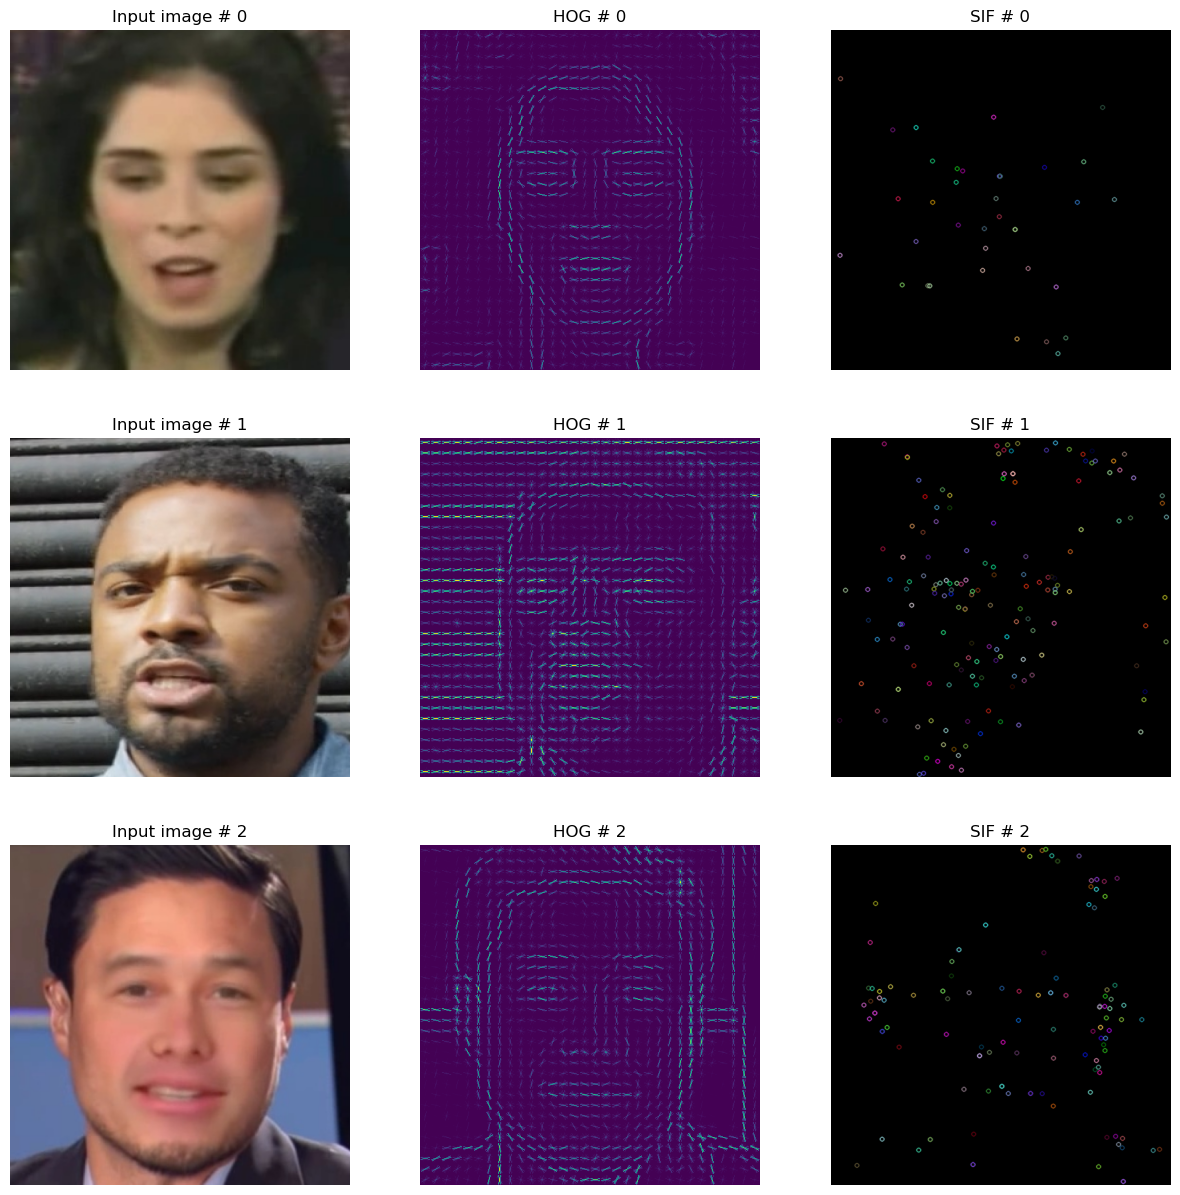

In [6]:
params = {'frames_path' : os.path.join('datasets','frames'),
          'phases' : ['train'],
          'сrop' : True,
#           'gray' : True,
          'sample_num' : 2,
          'H' : 512, 'W' : 512,
          'frac_h' : 0.8, 'frac_v' : 0.5,
}

# get pictures
_, y, x = get_pictures(**params)

# get HOG masks
hog_images = get_hog(x.copy())

# get SIF masks
sif_images = get_sif(x.copy())


n = 3
cmap=None
# cmap=plt.cm.gray

fig, axx = plt.subplots(n, 3, figsize=(15, 15), sharex=True, sharey=True)

for i in range(n):

    axx[i][0].axis('off')

    image = x[i]
    axx[i][0].imshow(image, cmap=cmap)
    axx[i][0].set_title(f'Input image # {i}')

    # HOG
    axx[i][1].axis('off')
    hog_image = hog_images[i]
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    axx[i][1].imshow(hog_image_rescaled, cmap=cmap)
    axx[i][1].set_title(f'HOG # {i}')

    # SIF
    axx[i][2].axis('off')
    sif_image = sif_images[i]

    axx[i][2].imshow(sif_image, cmap=cmap)
    axx[i][2].set_title(f'SIF # {i}')

plt.show()

# ML

In [7]:
def save_model(model, file_name = 'default_model.pkl'):
    """
    Сохранение модели в .pkl файл
    """
    try:
        os.mkdir('models')
    except:
        pass
    file_path = os.path.join('models', file_name)
    pickle.dump(model, open(file_path, 'wb'))
#     print(f'Model {name} saved successfully')


def load_model(file_name):
    """
    Загрузка сохраненной модели из .pkl файла
    """
    file_path = os.path.join('models', file_name)
    return pickle.load(open(file_path, 'rb'))

In [8]:
def train_model(Xtrain, ytrain, Xtest, ytest, model):
    model.fit(Xtrain, ytrain)
    pred = model.predict(Xtest)
    accuracy = accuracy_score(ytest, pred)
    return accuracy, model, pred

# 'liblinear', 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers

## ML Download Data

In [9]:
def convert_data(X, y, labels = {'real' : 0, 'fake' : 1}, is_shuffle = True, normalize=False):
    # Вытянем изображения в вектор
    X = np.asarray([el.ravel() for el in X])

    # закодируем 
    y = [labels[item] for item in y]
    if is_shuffle:
        X, y = shuffle(X, y, random_state=RANDOM_STATE)
    if normalize is True:
        return np.array(X)/255, np.array(y)
    return np.array(X), np.array(y)

In [10]:
params = {'frames_path' : os.path.join('datasets','frames'),
          'labels' : {'real' : 0, 'fake' : 1},
          'phases' : ['train'],
          'сrop' : True,
          'gray' : True,
          'sample_num' : 1500,
          'H' : 144, 'W' : 144,
          'frac_h' : 0.8, 'frac_v' : 0.5,
}

In [11]:
train_sample = 1500
test_sample = 500
hog_results = []
base_results = []


params['sample_num'] = train_sample
params['phases'] = ['train']
Xtrain, ytrain, Xtrain_crop = get_pictures(**params)

params['sample_num'] = test_sample
params['phases'] = ['test']
Xtest, ytest, Xtest_crop = get_pictures(**params)

# Base pictures
Xtrain_pic, ytrain_pic = convert_data(Xtrain.copy(), ytrain.copy())
Xtest_pic, ytest_pic = convert_data(Xtest.copy(), ytest.copy(), is_shuffle = False)

# Train LogisticRegression
t0 = time.time()
acc_lr_pic, lr_model_pic, pred_lr_pic = train_model(Xtrain_pic, ytrain_pic,
                                 Xtest_pic, ytest_pic, 
                                 LogisticRegression(solver='liblinear', 
                                                    random_state=RANDOM_STATE,
                                                    class_weight='balanced')
                                )
# save best lr model for base pictures
save_model(lr_model_pic, file_name = 'lr_model_pic_best.pkl')
work_time_lr_pic = str(datetime.timedelta(seconds=int(time.time() - t0)))
print('work_time_lr_pic',work_time_lr_pic)

# Train LGBM
t0 = time.time()
acc_lgbm_pic, lgbm_model_pic, pred_lgbm_pic = train_model(Xtrain_pic, ytrain_pic,
                                 Xtest_pic, ytest_pic, 
                                 LGBMClassifier(random_state=RANDOM_STATE,
                                                class_weight='balanced')
                                                         )
# save best lgbm model for base pictures
save_model(lgbm_model_pic, file_name = 'lgbm_model_pic_best.pkl')
work_time_lgbm_pic = str(datetime.timedelta(seconds=int(time.time() - t0)))
print('work_time_lgbm_pic',work_time_lgbm_pic)

# Train RandomForestClassifier
t0 = time.time()
acc_rfc_pic, rfc_model_pic, pred_rfc_pic = train_model(Xtrain_pic, ytrain_pic,
                                 Xtest_pic, ytest_pic, 
                                 RandomForestClassifier(random_state=RANDOM_STATE,
                                                        class_weight='balanced')
                                                         )

# save best rfc model for base pictures
save_model(rfc_model_pic, file_name = 'rfc_model_pic_best.pkl')
work_time_rfc_pic = str(datetime.timedelta(seconds=int(time.time() - t0)))
print('work_time_rfc_pic',work_time_rfc_pic)

# HOG pictures

Xtrain_hog = get_hog(Xtrain_crop.copy())
X_test_hog = get_hog(Xtest_crop.copy())

Xtrain_hog, ytrain_hog = convert_data(Xtrain_hog.copy(), ytrain.copy())
Xtest_hog, ytest_hog = convert_data(X_test_hog.copy(), ytest.copy(), is_shuffle = False)

# Train LogisticRegression
t0 = time.time()
acc_lr_hog, lr_model_hog, pred_lr_hog = train_model(Xtrain_hog, ytrain_hog,
                                 Xtest_hog, ytest_hog, 
                                 LogisticRegression(solver='liblinear', 
                                                    random_state=RANDOM_STATE,
                                                    class_weight='balanced')
                                )
# save best lr model for HOG pictures
save_model(lr_model_hog, file_name = 'lr_model_hog_best.pkl')
work_time_lr_hog = str(datetime.timedelta(seconds=int(time.time() - t0)))
print('work_time_lr_hog',work_time_lr_hog)

# Train LGBM
t0 = time.time()
acc_lgbm_hog, lgbm_model_hog, pred_lgbm_hog = train_model(Xtrain_hog, ytrain_hog,
                                 Xtest_hog, ytest_hog, 
                                 LGBMClassifier(random_state=RANDOM_STATE,
                                                class_weight='balanced')
                                                         )
# save best lgbm model for HOG pictures
save_model(lgbm_model_hog, file_name = 'lgbm_model_hog_best.pkl')
work_time_lgbm_hog = str(datetime.timedelta(seconds=int(time.time() - t0)))
print('work_time_lgbm_hog',work_time_lgbm_hog)

# Train RandomForestClassifier
t0 = time.time()
acc_rfc_hog, rfc_model_hog, pred_rfc_hog = train_model(Xtrain_hog, ytrain_hog,
                                 Xtest_hog, ytest_hog, 
                                 RandomForestClassifier(random_state=RANDOM_STATE,
                                                        class_weight='balanced')
                                                         )

# save best rfc model for HOG pictures
save_model(rfc_model_hog, file_name = 'rfc_model_hog_best.pkl')
work_time_rfc_hog = str(datetime.timedelta(seconds=int(time.time() - t0)))
print('work_time_rfc_hog',work_time_rfc_hog)


print('+'*100)
print(f'LR MODEL: accuracy for base pictures = {acc_lr_pic}, time={work_time_lr_pic}, accuracy for HOG pictures = {acc_lr_hog}, time={work_time_lr_hog}')
print(f'LGBM MODEL: accuracy for base pictures = {acc_lgbm_pic}, time={work_time_lgbm_pic}, accuracy for HOG pictures = {acc_lgbm_hog}, time={work_time_lgbm_hog}')
print(f'RFC MODEL: accuracy for base pictures = {acc_rfc_pic}, time={work_time_rfc_pic}, accuracy for HOG pictures = {acc_rfc_hog}, time={work_time_rfc_hog}')
print('+'*100)

phase:   0%|          | 0/1 [00:00<?, ?it/s]

downloading pictures:   0%|          | 0/1500 [00:00<?, ?it/s]

downloading pictures:   0%|          | 0/1500 [00:00<?, ?it/s]

No face found for 107 files
Downloaded 3000 pictures and 3000 labels


phase:   0%|          | 0/1 [00:00<?, ?it/s]

downloading pictures:   0%|          | 0/500 [00:00<?, ?it/s]

downloading pictures:   0%|          | 0/500 [00:00<?, ?it/s]

No face found for 31 files
Downloaded 1000 pictures and 1000 labels
work_time_lr_pic 0:02:23
work_time_lgbm_pic 0:01:18
work_time_rfc_pic 0:00:23


HOG transformation:   0%|          | 0/3000 [00:00<?, ?it/s]

HOG transformation:   0%|          | 0/1000 [00:00<?, ?it/s]

work_time_lr_hog 0:00:58
work_time_lgbm_hog 0:00:28
work_time_rfc_hog 0:00:14
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LR MODEL: accuracy for base pictures = 0.624, time=0:02:23, accuracy for HOG pictures = 0.628, time=0:00:58
LGBM MODEL: accuracy for base pictures = 0.654, time=0:01:18, accuracy for HOG pictures = 0.69, time=0:00:28
RFC MODEL: accuracy for base pictures = 0.655, time=0:00:23, accuracy for HOG pictures = 0.645, time=0:00:14
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


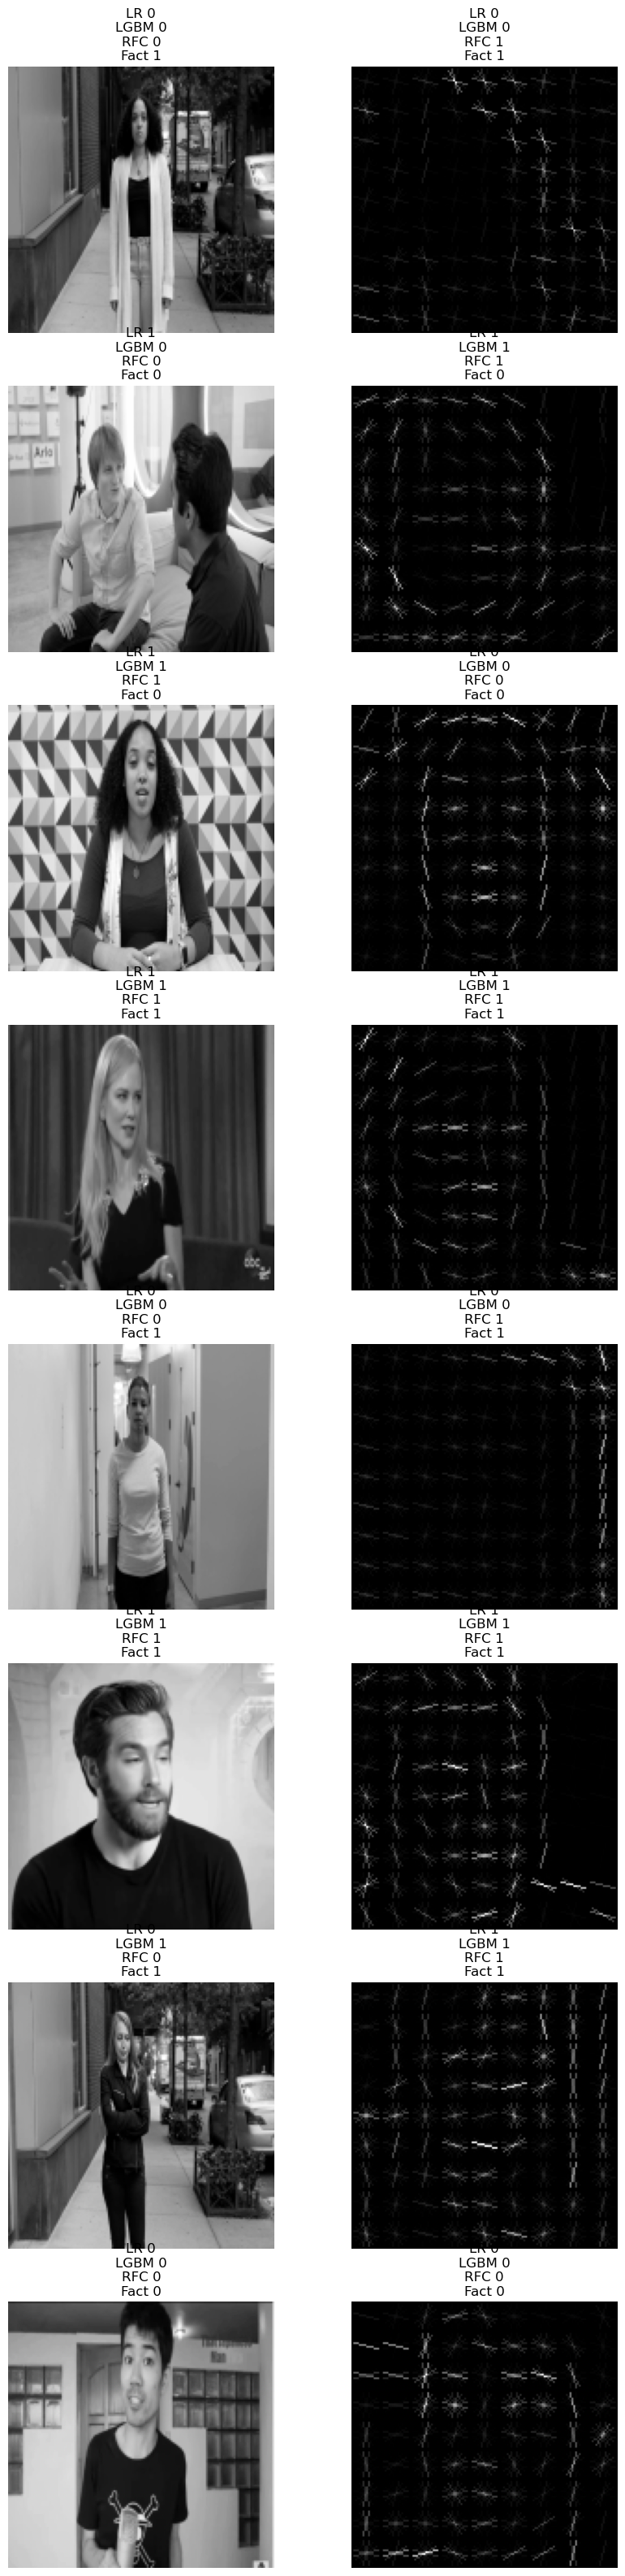

In [38]:
n = 8
cmap=None
cmap=plt.cm.gray

fig, axx = plt.subplots(n, 2, figsize=(10, n*5), sharex=True, sharey=True)

for i in range(n):
    idx = random.randrange(len(Xtest))
    

    axx[i][0].axis('off')

    image = Xtest[idx]
    axx[i][0].imshow(image, cmap=cmap)
    axx[i][0].set_title(f'LR {pred_lr_pic[idx]}\nLGBM {pred_lgbm_pic[idx]}\nRFC {pred_rfc_pic[idx]}\nFact {ytest_pic[idx]}')

    axx[i][1].axis('off')

    image_hog = X_test_hog[idx]
    axx[i][1].imshow(image_hog, cmap=cmap)
    axx[i][1].set_title(f'LR {pred_lr_hog[idx]}\nLGBM {pred_lgbm_hog[idx]}\nRFC {pred_rfc_hog[idx]}\nFact {ytest_hog[idx]}')

plt.show()

In [13]:
labels = {'real' : 0, 'fake' : 1}

In [47]:
pred = np.round((pred_lgbm_pic+pred_rfc_pic+pred_lgbm_hog+pred_rfc_hog)/4)

In [48]:
accuracy_score(ytest_hog,pred)

0.715